In [89]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt  
from sklearn.cluster import KMeans
from sklearn import metrics
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import confusion_matrix

### Carregando a base

In [2]:
headers = ['sepal length', 'sepal width', 'petal length', 'petal width', 'class']
dataset = pd.read_csv("./iris.data", encoding = "ISO-8859-1", decimal=",", header=None, names=headers)
dataset.head()

,sepal length,sepal width,petal length,petal width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [3]:
for col in  dataset.columns[0:4]:
    dataset[col] = dataset[col].astype(float)

In [4]:
#dataset.groupby(['class'])
#Obtendo as classificações
rotulos = pd.Series(list(dataset["class"])).unique()
rotulos

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

In [5]:
for x in rotulos:
  print(x)

Iris-setosa
Iris-versicolor
Iris-virginica


In [6]:
#Verificando melhor valor de K utilizando o método Silhouette
def get_best_k_value(base, percent = 0.5, isDebug = False):
    averagesSC = pd.DataFrame(columns=['averageSC', 'k'])
    for i in range(2, int(base.shape[0] * percent)):
        try:
            #visu = SilhouetteVisualizer(KMeans(n_clusters=i, init="k-means++", max_iter=300, n_init=10))
            #visu = SilhouetteVisualizer(KMeans(n_clusters=i))
            #visu.fit(base)
            #visu.show()   
            kmeans_model = KMeans(n_clusters=i, init="k-means++").fit(base)
            labels = kmeans_model.labels_
            score = metrics.silhouette_score(base, labels, metric='euclidean')
            new_row = {}
            new_row["averageSC"] = score
            new_row["k"] = i
            averagesSC = averagesSC.append(new_row, ignore_index=True)
        except:
          print("Ignorando {value_i}".format(value_i = i))
        finally:
          continue
        
    if isDebug :
        return averagesSC
    else:
        return averagesSC[averagesSC['averageSC'] == averagesSC['averageSC'].max()].iloc[0]['k']
    


In [7]:
df_regras = pd.DataFrame()
for rotulo in rotulos:
    
    subconj = dataset[dataset["class"] == rotulo]
    subconj = subconj.drop(['class'], axis=1)
    
    media = subconj.mean(axis=1) #Média de cada linha
    desvio_padrao = subconj.std(ddof=0, axis=1) #Desvio padrão, da população N (ddof=0), de cada linha
    # Step 1 (2)
    subconj_calc_step_1_2 = subconj.sub(media, axis='index').div(desvio_padrao, axis='index')
    
    # Step 1 (3)
    maior = subconj_calc_step_1_2.max(axis=1) #Maior valor de cada linha
    menor = subconj_calc_step_1_2.min(axis=1) #Menor valor de cada linha
    subconj_calc_step_1_2 = subconj_calc_step_1_2.sub(menor, axis='index').div(maior.sub(menor, axis='index'), axis='index')
    
    # Verificando melhor valor p/ o k
    k = int(get_best_k_value(base = subconj_calc_step_1_2))
    print("---------------------------------------------------------------------")
    print("Valor de k = {}".format(k))
    # Executando o K-Means
    kmeans = KMeans(n_clusters=k, init="k-means++").fit(subconj_calc_step_1_2)
    informacoes_clustered = kmeans.fit_predict(subconj_calc_step_1_2)    
    results = subconj_calc_step_1_2.copy()
    results['clusterNumber'] = informacoes_clustered
    
    #Step 6 (11)
    print("Step 6 (11)")  
    subrotulos = pd.Series(list(results["clusterNumber"])).unique()
    #print(sorted(subrotulos))
    #str_regra = ""
    #for subrotulo in sorted(subrotulos):
    #    count = 1                
    #    regras = results[results["clusterNumber"] == subrotulo]
    #    regras = regras.drop(['clusterNumber'], axis=1)
    #    
    #    for index, row in regras.iterrows():
    #        if count == 1:
    #            str_regra = str_regra + " \n \n Rl: IF (x ~ "
    #        else:
    #            str_regra = str_regra +  "   \n  OR (x ~ "
    #            
    #        clmn = regras.columns.tolist()
    #        count_col = 1       
    #        for nome_coluna in clmn:                
    #            value = str(row[nome_coluna])
    #            if count_col != regras.shape[1]:
    #                str_regra = str_regra + value + ", "                    
    #            else:
    #                str_regra = str_regra + value + ")"
    #    
    #            if count_col == len(clmn) and count == regras.shape[0]:
    #                str_regra = str_regra + " THEN (" + rotulo + ")"
    #            count_col += 1
    #            
    #        count += 1
    #print(str_regra)    
    
    
    #B. Hierarchical organisation of the prototypes (13)
    print("\nB. Hierarchical organisation of the prototypes (13) ")  
    #print(sorted(subrotulos))
    str_regra = ""
    count = 1   
    for subrotulo in sorted(subrotulos):                        
            regras = results[results["clusterNumber"] == subrotulo]
            regras = regras.drop(['clusterNumber'], axis=1)
            
            #B. Hierarchical organisation of the prototypes (13) primeiro fazendo o cálculo de pj/P
            regras = regras/regras.shape[0]
            #B. Hierarchical organisation of the prototypes (13) aplicando o somatório e gerando a regra consolidada
            regras = regras.sum(axis=0).to_frame().transpose()
            
            v_regras = regras.copy()
            v_regras['class'] = rotulo
            print(v_regras)
            df_regras = df_regras.append(v_regras, ignore_index=True)
            
            if count == 1:
                str_regra = str_regra + " \n Rl: IF (x ~ "
            else:
                str_regra = str_regra +  "   \n  OR (x ~ "
                
            for index, row in regras.iterrows():                                  
                clmn = regras.columns.tolist()
                count_col = 1       
                for nome_coluna in clmn:                
                    value = str(round(row[nome_coluna], 6))
                    if count_col != regras.shape[1]:
                        str_regra = str_regra + value + ", "                    
                    else:
                        str_regra = str_regra + value + ")"
            
                    if count_col == len(clmn) and count == len(subrotulos):
                        str_regra = str_regra + " THEN (" + rotulo + ")"
                    count_col += 1
                    
            count += 1
    print(str_regra) 


---------------------------------------------------------------------
Valor de k = 12
Step 6 (11)

B. Hierarchical organisation of the prototypes (13) 
   sepal length  sepal width  petal length  petal width        class
0           1.0      0.76072       0.20526          0.0  Iris-setosa
   sepal length  sepal width  petal length  petal width        class
0           1.0     0.636179      0.295011          0.0  Iris-setosa
   sepal length  sepal width  petal length  petal width        class
0           1.0      0.66887      0.223068          0.0  Iris-setosa
   sepal length  sepal width  petal length  petal width        class
0           1.0     0.615881       0.21196          0.0  Iris-setosa
   sepal length  sepal width  petal length  petal width        class
0           1.0     0.706449      0.250595          0.0  Iris-setosa
   sepal length  sepal width  petal length  petal width        class
0           1.0      0.47619      0.238095          0.0  Iris-setosa
   sepal length  sep

In [8]:
df_regras

,sepal length,sepal width,petal length,petal width,class
0,1.0,0.760720,0.205260,0.0,Iris-setosa
1,1.0,0.636179,0.295011,0.0,Iris-setosa
2,1.0,0.668870,0.223068,0.0,Iris-setosa
3,1.0,0.615881,0.211960,0.0,Iris-setosa
4,1.0,0.706449,0.250595,0.0,Iris-setosa
5,1.0,0.476190,0.238095,0.0,Iris-setosa
6,1.0,0.695652,0.369565,0.0,Iris-setosa
7,1.0,0.660632,0.256687,0.0,Iris-setosa
8,1.0,0.600959,0.265779,0.0,Iris-setosa
9,1.0,0.717917,0.303070,0.0,Iris-setosa


# Density-Based Input Selection

In [9]:
conj = dataset.drop(['class'], axis=1)   
conj

,sepal length,sepal width,petal length,petal width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [10]:
media = conj.mean(axis=1) #Média de cada linha
media

0      2.550
1      2.375
2      2.350
3      2.350
4      2.550
       ...  
145    4.300
146    3.925
147    4.175
148    4.325
149    3.950
Length: 150, dtype: float64

In [11]:
desvio_padrao = conj.std(ddof=0, axis=1) #Desvio padrão, da população N (ddof=0), de cada linha
desvio_padrao

0      1.887459
1      1.764051
2      1.729884
3      1.656050
4      1.867485
         ...   
145    1.750714
146    1.797742
147    1.772533
148    1.551411
149    1.631717
Length: 150, dtype: float64

In [12]:
# Step 1 (2)
conj_calc_step_1_2 = conj.sub(media, axis='index').div(desvio_padrao, axis='index')
conj_calc_step_1_2

,sepal length,sepal width,petal length,petal width
0,1.351023,0.503322,-0.609285,-1.245060
1,1.431365,0.354298,-0.552705,-1.232958
2,1.358472,0.491362,-0.606977,-1.242858
3,1.358655,0.452885,-0.513270,-1.298270
4,1.311925,0.562254,-0.615801,-1.258377
...,...,...,...,...
145,1.370869,-0.742554,0.514076,-1.142391
146,1.321102,-0.792661,0.597972,-1.126413
147,1.311682,-0.662893,0.578268,-1.227057
148,1.208577,-0.596232,0.692918,-1.305264


In [13]:
# Step 1 (3)
maior = conj_calc_step_1_2.max(axis=1) #Maior valor de cada linha
menor = conj_calc_step_1_2.min(axis=1) #Menor valor de cada linha
conj_calc_step_1_2 = conj_calc_step_1_2.sub(menor, axis='index').div(maior.sub(menor, axis='index'), axis='index')
conj_calc_step_1_2

,sepal length,sepal width,petal length,petal width
0,1.0,0.673469,0.244898,0.0
1,1.0,0.595745,0.255319,0.0
2,1.0,0.666667,0.244444,0.0
3,1.0,0.659091,0.295455,0.0
4,1.0,0.708333,0.250000,0.0
...,...,...,...,...
145,1.0,0.159091,0.659091,0.0
146,1.0,0.136364,0.704545,0.0
147,1.0,0.222222,0.711111,0.0
148,1.0,0.282051,0.794872,0.0


In [14]:
media = conj_calc_step_1_2.mean(axis=1) #Média de cada linha
media

0      0.479592
1      0.462766
2      0.477778
3      0.488636
4      0.489583
         ...   
145    0.454545
146    0.460227
147    0.483333
148    0.519231
149    0.524390
Length: 150, dtype: float64

In [15]:
desvio_padrao = conj_calc_step_1_2.std(ddof=0, axis=1) #Desvio padrão, da população N (ddof=0), de cada linha
desvio_padrao

0      0.385196
1      0.375330
2      0.384419
3      0.376375
4      0.389059
         ...   
145    0.397890
146    0.408578
147    0.393896
148    0.397798
149    0.397980
Length: 150, dtype: float64

# C. Density-Based Input Selection (14)

In [16]:
#C. Density-Based Input Selection (14)
#=1/(1 + (POTÊNCIA(RAIZ(POTÊNCIA(C4-H4;2));2)/POTÊNCIA(I4;2)))
conj_calc_step_1_2 = conj_calc_step_1_2.sub(media, axis='index')
conj_calc_step_1_2

,sepal length,sepal width,petal length,petal width
0,0.520408,0.193878,-0.234694,-0.479592
1,0.537234,0.132979,-0.207447,-0.462766
2,0.522222,0.188889,-0.233333,-0.477778
3,0.511364,0.170455,-0.193182,-0.488636
4,0.510417,0.218750,-0.239583,-0.489583
...,...,...,...,...
145,0.545455,-0.295455,0.204545,-0.454545
146,0.539773,-0.323864,0.244318,-0.460227
147,0.516667,-0.261111,0.227778,-0.483333
148,0.480769,-0.237179,0.275641,-0.519231


In [17]:
conj_calc_step_1_2 = conj_calc_step_1_2.pow(2, axis='index')
conj_calc_step_1_2

,sepal length,sepal width,petal length,petal width
0,0.270825,0.037589,0.055081,0.230008
1,0.288620,0.017683,0.043034,0.214152
2,0.272716,0.035679,0.054444,0.228272
3,0.261493,0.029055,0.037319,0.238765
4,0.260525,0.047852,0.057400,0.239692
...,...,...,...,...
145,0.297521,0.087293,0.041839,0.206612
146,0.291355,0.104888,0.059691,0.211809
147,0.266944,0.068179,0.051883,0.233611
148,0.231139,0.056254,0.075978,0.269601


In [18]:
conj_calc_step_1_2 = conj_calc_step_1_2 ** (1/2)
conj_calc_step_1_2

,sepal length,sepal width,petal length,petal width
0,0.520408,0.193878,0.234694,0.479592
1,0.537234,0.132979,0.207447,0.462766
2,0.522222,0.188889,0.233333,0.477778
3,0.511364,0.170455,0.193182,0.488636
4,0.510417,0.218750,0.239583,0.489583
...,...,...,...,...
145,0.545455,0.295455,0.204545,0.454545
146,0.539773,0.323864,0.244318,0.460227
147,0.516667,0.261111,0.227778,0.483333
148,0.480769,0.237179,0.275641,0.519231


In [19]:
conj_calc_step_1_2 = conj_calc_step_1_2.pow(2, axis='index')
conj_calc_step_1_2

,sepal length,sepal width,petal length,petal width
0,0.270825,0.037589,0.055081,0.230008
1,0.288620,0.017683,0.043034,0.214152
2,0.272716,0.035679,0.054444,0.228272
3,0.261493,0.029055,0.037319,0.238765
4,0.260525,0.047852,0.057400,0.239692
...,...,...,...,...
145,0.297521,0.087293,0.041839,0.206612
146,0.291355,0.104888,0.059691,0.211809
147,0.266944,0.068179,0.051883,0.233611
148,0.231139,0.056254,0.075978,0.269601


In [20]:
conj_calc_step_1_2 = conj_calc_step_1_2.div(desvio_padrao.pow(2, axis='index'), axis='index')
conj_calc_step_1_2

,sepal length,sepal width,petal length,petal width
0,1.825263,0.253333,0.371228,1.550175
1,2.048805,0.125527,0.305483,1.520185
2,1.845447,0.241437,0.368421,1.544695
3,1.845943,0.205105,0.263446,1.685506
4,1.721147,0.316129,0.379211,1.583513
...,...,...,...,...
145,1.879282,0.551387,0.264274,1.305057
146,1.745310,0.628312,0.357571,1.268807
147,1.720509,0.439427,0.334394,1.505669
148,1.460660,0.355492,0.480135,1.703713


In [21]:
conj_calc_step_1_2 = 1/(conj_calc_step_1_2 + 1)
conj_calc_step_1_2

,sepal length,sepal width,petal length,petal width
0,0.353949,0.797872,0.729273,0.392130
1,0.327997,0.888473,0.766000,0.396796
2,0.351439,0.805518,0.730769,0.392974
3,0.351377,0.829803,0.791486,0.372369
4,0.367492,0.759804,0.725052,0.387070
...,...,...,...,...
145,0.347309,0.644585,0.790968,0.433829
146,0.364258,0.614133,0.736610,0.440760
147,0.367578,0.694721,0.749404,0.399095
148,0.406395,0.737739,0.675614,0.369862


# C. Density-Based Input Selection (15)

In [22]:
#C. Density-Based Input Selection (15)
conj_calc_step_1_2 = conj_calc_step_1_2.sum(axis=0)
conj_calc_step_1_2

sepal length     54.808481
sepal width     115.128602
petal length    114.459094
petal width      58.118992
dtype: float64

In [23]:
conj_calc_step_1_2.to_frame()#.transpose()

,0
sepal length,54.808481
sepal width,115.128602
petal length,114.459094
petal width,58.118992


-----------------------------

# Rascunho ...

- SC ≤ 0,25 → Nenhuma estrutura relevante encontrada
- 0,26 ≤ SC ≤ 0,5 → Estrutura fraca/artificial
- 0,51 ≤ SC ≤ 0,7 → Estrutura razoável
- 0,71 ≤ SC ≤ 1 → Estrutura forte

In [24]:
#Test
df = dataset[dataset["class"] == "Iris-setosa"]
df = df.drop(['class'], axis=1)
media = df.mean(axis=1)
desvio = df.std(ddof=0, axis=1)

calculado_step_1_2 = df.sub(media, axis='index').div(desvio, axis='index')

maior = calculado_step_1_2.max(axis=1)
menor = calculado_step_1_2.min(axis=1)

calculado_step_1_3 = calculado_step_1_2.sub(menor, axis='index').div(maior.sub(menor, axis='index'), axis='index')
calculado_step_1_3


#visualizer = KElbowVisualizer(KMeans(init="k-means++", max_iter=300, n_init=10), k=(2,15)) #init="k-means++"

#visualizer.fit(calculado_step_1_3)        # Fit the data to the visualizer
#visualizer.show()        # Finalize and render the figure




,sepal length,sepal width,petal length,petal width
0,1.0,0.673469,0.244898,0.0
1,1.0,0.595745,0.255319,0.0
2,1.0,0.666667,0.244444,0.0
3,1.0,0.659091,0.295455,0.0
4,1.0,0.708333,0.250000,0.0
5,1.0,0.700000,0.260000,0.0
6,1.0,0.720930,0.255814,0.0
7,1.0,0.666667,0.270833,0.0
8,1.0,0.642857,0.285714,0.0
9,1.0,0.625000,0.291667,0.0


In [25]:
calculado_step_1_3.shape[0]
calculado_step_1_3.sum(axis=0).to_frame().transpose()

,sepal length,sepal width,petal length,petal width
0,50.0,33.298294,12.844805,0.0


In [26]:
calculado_step_1_3

,sepal length,sepal width,petal length,petal width
0,1.0,0.673469,0.244898,0.0
1,1.0,0.595745,0.255319,0.0
2,1.0,0.666667,0.244444,0.0
3,1.0,0.659091,0.295455,0.0
4,1.0,0.708333,0.250000,0.0
5,1.0,0.700000,0.260000,0.0
6,1.0,0.720930,0.255814,0.0
7,1.0,0.666667,0.270833,0.0
8,1.0,0.642857,0.285714,0.0
9,1.0,0.625000,0.291667,0.0


In [27]:
#Test 
#averagesSC = 
averagesSC = get_best_k_value(base = calculado_step_1_3, isDebug = True)
averagesSC[averagesSC['averageSC'] == averagesSC['averageSC'].max()]


,averageSC,k
6,0.400203,8.0


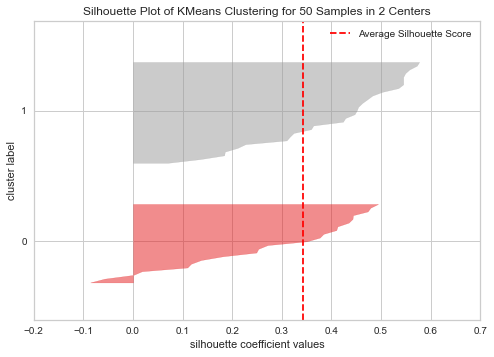

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 50 Samples in 2 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [28]:
visu = SilhouetteVisualizer(KMeans(2))
visu.fit(calculado_step_1_3)
visu.show()

## Executando "Fuzzy Control Systems: The Tipping Problem"

In [29]:
import skfuzzy as fuzz
from skfuzzy import control as ctrl

In [30]:
dataset

,sepal length,sepal width,petal length,petal width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


In [31]:
classe = dataset[['class']].copy()
base_sem_rotulo = dataset.drop(['class'], axis=1)

media = base_sem_rotulo.mean(axis=1) #Média de cada linha
desvio_padrao = base_sem_rotulo.std(ddof=0, axis=1) #Desvio padrão, da população N (ddof=0), de cada linha
# Step 1 (2)
base_sem_rotulo_calc_step_1_2 = base_sem_rotulo.sub(media, axis='index').div(desvio_padrao, axis='index')

# Step 1 (3)
maior = base_sem_rotulo_calc_step_1_2.max(axis=1) #Maior valor de cada linha
menor = base_sem_rotulo_calc_step_1_2.min(axis=1) #Menor valor de cada linha
base_padronizada = base_sem_rotulo_calc_step_1_2.sub(menor, axis='index').div(maior.sub(menor, axis='index'), axis='index')

In [32]:
base_padronizada['class'] = classe
base_padronizada

,sepal length,sepal width,petal length,petal width,class
0,1.0,0.673469,0.244898,0.0,Iris-setosa
1,1.0,0.595745,0.255319,0.0,Iris-setosa
2,1.0,0.666667,0.244444,0.0,Iris-setosa
3,1.0,0.659091,0.295455,0.0,Iris-setosa
4,1.0,0.708333,0.250000,0.0,Iris-setosa
...,...,...,...,...,...
145,1.0,0.159091,0.659091,0.0,Iris-virginica
146,1.0,0.136364,0.704545,0.0,Iris-virginica
147,1.0,0.222222,0.711111,0.0,Iris-virginica
148,1.0,0.282051,0.794872,0.0,Iris-virginica


In [33]:
#setosa = base_padronizada[base_padronizada['class'] == 'Iris-setosa']
#virginica = base_padronizada[base_padronizada['class'] == 'Iris-virginica']
#versicolor = base_padronizada[base_padronizada['class'] == 'Iris-versicolor']
#versicolor
setosa = df_regras[df_regras['class'] == 'Iris-setosa']
virginica = df_regras[df_regras['class'] == 'Iris-virginica']
versicolor = df_regras[df_regras['class'] == 'Iris-versicolor']
versicolor

,sepal length,sepal width,petal length,petal width,class
12,1.0,0.401480,0.658973,0.0,Iris-versicolor
13,1.0,0.318247,0.599168,0.0,Iris-versicolor
14,1.0,0.229403,0.638235,0.0,Iris-versicolor
15,1.0,0.343443,0.731503,0.0,Iris-versicolor
16,1.0,0.250000,0.795455,0.0,Iris-versicolor
17,1.0,0.336150,0.658172,0.0,Iris-versicolor
18,1.0,0.354173,0.513933,0.0,Iris-versicolor


#### Análise

In [34]:
dict_setosa = {
    'min_sepal_width' : setosa['sepal width'].min(),
    'max_sepal_width' : setosa['sepal width'].max(),
    'min_petal_length' : setosa['petal length'].min(),
    'max_petal_length' : setosa['petal length'].max(),
    'class' : 'setosa'
}


In [35]:
dict_virginica = {
    'min_sepal_width' : virginica['sepal width'].min(),
    'max_sepal_width' : virginica['sepal width'].max(),
    'min_petal_length' : virginica['petal length'].min(),
    'max_petal_length' : virginica['petal length'].max(),
    'class' : 'virginica'
}

In [36]:
dict_versicolor = {
    'min_sepal_width' : versicolor['sepal width'].min(),
    'max_sepal_width' : versicolor['sepal width'].max(),
    'min_petal_length' : versicolor['petal length'].min(),
    'max_petal_length' : versicolor['petal length'].max(),
    'class' : 'versicolor'
}

In [37]:
dfObj = pd.DataFrame.from_dict(dict_setosa, orient='index')
dfObj = dfObj.transpose()
dfObj = dfObj.append(dict_virginica, ignore_index=True)
dfObj = dfObj.append(dict_versicolor, ignore_index=True)

#dfObj.sort_values(["max_sepal_width"], ascending=[True])[["max_sepal_width", "class"]]
dfObj

,min_sepal_width,max_sepal_width,min_petal_length,max_petal_length,class
0,0.47619,0.784314,0.179286,0.369565,setosa
1,0.0555556,0.284134,0.633893,0.883529,virginica
2,0.229403,0.40148,0.513933,0.795455,versicolor


In [38]:
dfObj.sort_values(["min_petal_length"], ascending=[True])[["min_petal_length", "class"]]

,min_petal_length,class
0,0.179286,setosa
2,0.513933,versicolor
1,0.633893,virginica


In [39]:
dfObj.sort_values(["max_petal_length"], ascending=[True])[["max_petal_length", "class"]]

,max_petal_length,class
0,0.369565,setosa
2,0.795455,versicolor
1,0.883529,virginica


In [40]:
interval_setosa_sepal_width = pd.Interval(left=dict_setosa['min_sepal_width'], right=dict_setosa['max_sepal_width'])
interval_setosa_sepal_width

Interval(0.47619047619047616, 0.784313725490196, closed='right')

In [41]:
interval_setosa_petal_length = pd.Interval(left=dict_setosa['min_petal_length'], right=dict_setosa['max_petal_length'])
interval_setosa_petal_length

Interval(0.17928571428571427, 0.3695652173913043, closed='right')

In [42]:
interval_versicolor_sepal_width = pd.Interval(left=dict_versicolor['min_sepal_width'], right=dict_versicolor['max_sepal_width'])
interval_versicolor_sepal_width

Interval(0.22940266676673296, 0.4014799154334038, closed='right')

In [43]:
interval_versicolor_petal_length = pd.Interval(left=dict_versicolor['min_petal_length'], right=dict_versicolor['max_petal_length'])
interval_versicolor_petal_length

Interval(0.5139328715157513, 0.7954545454545453, closed='right')

In [44]:
interval_virginica_sepal_width = pd.Interval(left=dict_virginica['min_sepal_width'], right=dict_virginica['max_sepal_width'])
interval_virginica_sepal_width

Interval(0.05555555555555558, 0.2841338663963812, closed='right')

In [45]:
interval_virginica_petal_length = pd.Interval(left=dict_virginica['min_petal_length'], right=dict_virginica['max_petal_length'])
interval_virginica_petal_length

Interval(0.633893280632411, 0.8835285243249968, closed='right')

In [46]:
interval_setosa_sepal_width.overlaps(interval_versicolor_sepal_width)

False

In [47]:
interval_setosa_sepal_width.overlaps(interval_virginica_sepal_width)

False

In [48]:
interval_versicolor_sepal_width.overlaps(interval_virginica_sepal_width)

True

In [49]:
interval_setosa_petal_length.overlaps(interval_versicolor_petal_length)

False

In [50]:
interval_setosa_petal_length.overlaps(interval_virginica_petal_length)

False

In [51]:
interval_versicolor_petal_length.overlaps(interval_virginica_petal_length)

True

In [52]:
i1 = pd.Interval(left=0, right=5)
i2 = pd.Interval(left=5, right=7)
i3 = pd.Interval(left=6, right=10)

In [53]:
i1.overlaps(i3)

False

In [54]:
i1.overlaps(i2)

False

In [55]:
sepal_width_array = base_padronizada['sepal width'].to_numpy()
sepal_width_array = np.sort(sepal_width_array)
petal_length_array = base_padronizada['petal length'].to_numpy()
petal_length_array = np.sort(petal_length_array)

In [56]:
# New Antecedent/Consequent objects hold universe variables and membership
# functions
sepal_length = ctrl.Antecedent(np.arange(0, 1.1, 0.1), 'sepal_length') #array([0, 1])
sepal_width = ctrl.Antecedent(sepal_width_array, 'sepal_width')
petal_length = ctrl.Antecedent(petal_length_array, 'petal_length')
petal_width = ctrl.Antecedent(np.arange(0, 1.1, 0.1), 'petal_width')
cls = ctrl.Consequent(np.array([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0]), 'cls')

# Auto-membership function population is possible with .automf(3, 5, or 7)
names = ['pequeno', 'medio', 'grande']
#names = ['pequeno-minimo', 'pequeno-medio', 'pequeno-grande', 'grande-minimo', 'grande-medio', 'grande-grande']
names_cls = ['setosa', 'versicolor', 'virginica']

sepal_length.automf(names = names)
sepal_width.automf(names = names)
petal_length.automf(names = names)
petal_width.automf(names = names)
#cls.automf(names = names_cls)
cls['setosa'] = fuzz.trimf(cls.universe, [0.0, 0.0, 2.0])
cls['versicolor'] = fuzz.trimf(cls.universe, [2.0, 3.0, 4.0])
cls['virginica'] = fuzz.trimf(cls.universe, [4.0, 6.0, 6.0])

C:\Users\angel\anaconda3\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


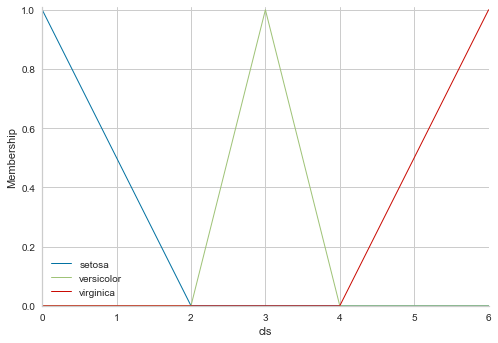

In [57]:
cls.view()

C:\Users\angel\anaconda3\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


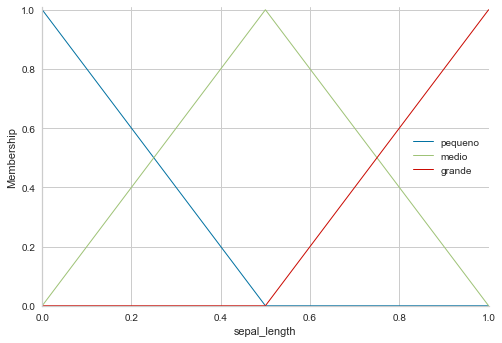

In [58]:
# You can see how these look with .view()
sepal_length.view()

C:\Users\angel\anaconda3\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


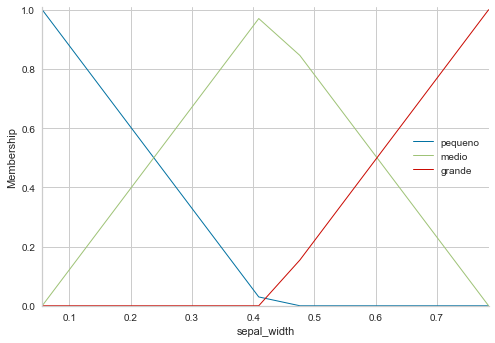

In [59]:
sepal_width.view()

C:\Users\angel\anaconda3\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


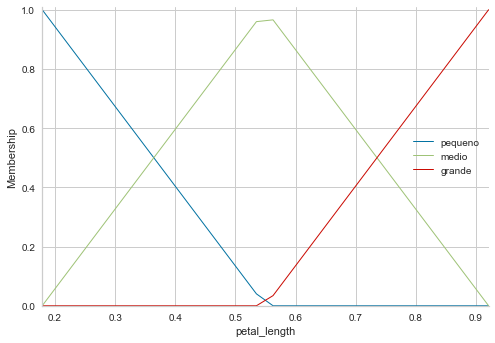

In [60]:
petal_length.view()

C:\Users\angel\anaconda3\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


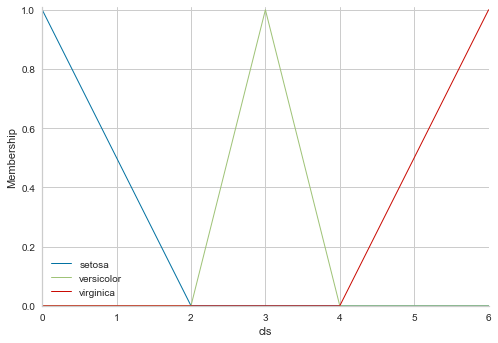

In [61]:
cls.view()

rule0 = ctrl.Rule(antecedent=((sepal_length['grande'] & sepal_width['grande'] &
                              petal_length['pequeno'] & petal_width['pequeno'])),
                  consequent=cls['setosa'], label='rule setosa')

rule1 = ctrl.Rule(antecedent=(sepal_length['grande'] & sepal_width['medio'] &
                              petal_length['medio'] & petal_width['pequeno']),
                  consequent=cls['versicolor'], label='rule versicolor')


rule2 = ctrl.Rule(antecedent=(sepal_length['grande'] & sepal_width['pequeno'] & 
                              petal_length['grande'] & petal_width['pequeno']),
                  consequent=cls['virginica'], label='rule virginica')
                  

rule0 = ctrl.Rule(antecedent=((sepal_length['grande-grande'] & 
                               (sepal_width['pequeno-grande'] | sepal_width['grande-grande']) &
                              (petal_length['pequeno-minimo'] | petal_length['grande-minimo']) & 
                               petal_width['pequeno-minimo'])),
                  consequent=cls['setosa'], label='rule setosa')

rule1 = ctrl.Rule(antecedent=((sepal_length['grande-grande'] & 
                               (sepal_width['pequeno-medio'] | sepal_width['grande-medio']) &
                              (petal_length['pequeno-medio'] | petal_length['grande-medio']) & 
                               petal_width['pequeno-minimo'])),
                  consequent=cls['versicolor'], label='rule versicolor')


rule2 = ctrl.Rule(antecedent=((sepal_length['grande-grande'] & 
                               (sepal_width['pequeno-minimo'] | sepal_width['grande-minimo']) &
                              (petal_length['pequeno-grande'] | petal_length['grande-grande']) & 
                               petal_width['pequeno-minimo'])),
                  consequent=cls['virginica'], label='rule virginica')

In [62]:
dfObj

,min_sepal_width,max_sepal_width,min_petal_length,max_petal_length,class
0,0.47619,0.784314,0.179286,0.369565,setosa
1,0.0555556,0.284134,0.633893,0.883529,virginica
2,0.229403,0.40148,0.513933,0.795455,versicolor


C:\Users\angel\anaconda3\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


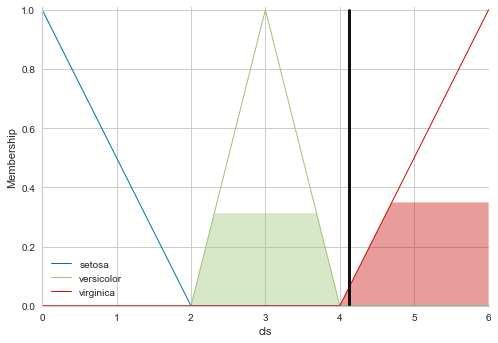

In [63]:

rule0 = ctrl.Rule(antecedent=((sepal_length['grande'] & sepal_width['grande'] &
                              petal_length['pequeno'] & petal_width['pequeno'])),
                  consequent=cls['setosa'], label='rule setosa')

rule1 = ctrl.Rule(antecedent=(sepal_length['grande'] & sepal_width['medio'] &
                              petal_length['medio'] & petal_width['pequeno']),
                  consequent=cls['versicolor'], label='rule versicolor')


rule2 = ctrl.Rule(antecedent=(sepal_length['grande'] & sepal_width['pequeno'] & 
                              petal_length['grande'] & petal_width['pequeno']),
                  consequent=cls['virginica'], label='rule virginica')
                  

#Código comentado
#rule1 = ctrl.Rule(antecedent=((error['nb'] & delta['ze']) |
#                              (error['nb'] & delta['ps']) |
#                              (error['ns'] & delta['ns']) |
#                              (error['ns'] & delta['ze']) |
#                              (error['ze'] & delta['ns']) |
#                              (error['ze'] & delta['nb']) |
#                              (error['ps'] & delta['nb'])),
#                  consequent=output['ns'], label='rule ns')

#rule2 = ctrl.Rule(antecedent=((error['nb'] & delta['pb']) |
#                              (error['ns'] & delta['ps']) |
#                              (error['ze'] & delta['ze']) |
#                              (error['ps'] & delta['ns']) |
#                              (error['pb'] & delta['nb'])),
#                  consequent=output['ze'], label='rule ze')
                  
system = ctrl.ControlSystem(rules=[rule0, rule1, rule2])
simulation = ctrl.ControlSystemSimulation(system)
# Pass inputs to the ControlSystem using Antecedent labels with Pythonic API
# Note: if you like passing many inputs all at once, use .inputs(dict_of_data)
# Virginica
simulation.inputs({
    'sepal_length': 1.0,
    'sepal_width': 0.292683,
    'petal_length':0.804878,
    'petal_width': 0.0
})


# Crunch the numbers
simulation.compute()

cls.view(sim=simulation) 

In [64]:
simulation.output['cls']

4.128679937654693

In [65]:
RESULT = simulation.output['cls']
print("Pertinence tip setosa: \t" + str(fuzz.interp_membership(cls.universe, cls['setosa'].mf, RESULT)))
print("Pertinence tip versicolor: \t" + str(fuzz.interp_membership(cls.universe, cls['versicolor'].mf, RESULT)))
print("Pertinence tip virginica: \t" + str(fuzz.interp_membership(cls.universe, cls['virginica'].mf, RESULT)))

Pertinence tip setosa: 	0.0
Pertinence tip versicolor: 	0.0
Pertinence tip virginica: 	0.06433996882734672


C:\Users\angel\anaconda3\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


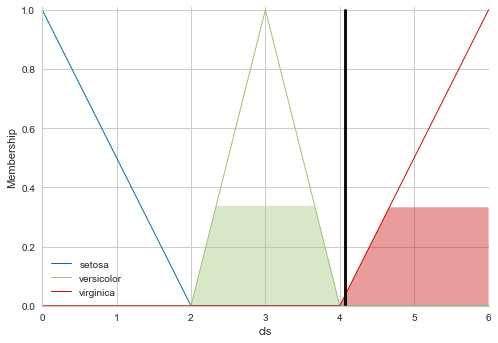

In [66]:
#Versicolor
simulation.inputs({
    'sepal_length': 1.0,
    'sepal_width': 0.178635,
    'petal_length':0.673316,
    'petal_width': 0.0
})
# Crunch the numbers
simulation.compute()

cls.view(sim=simulation) 

In [67]:
simulation.output['cls']

4.071092055058214

In [68]:
RESULT = simulation.output['cls']
print("Pertinence tip setosa: \t" + str(fuzz.interp_membership(cls.universe, cls['setosa'].mf, RESULT)))
print("Pertinence tip versicolor: \t" + str(fuzz.interp_membership(cls.universe, cls['versicolor'].mf, RESULT)))
print("Pertinence tip virginica: \t" + str(fuzz.interp_membership(cls.universe, cls['virginica'].mf, RESULT)))

Pertinence tip setosa: 	0.0
Pertinence tip versicolor: 	0.0
Pertinence tip virginica: 	0.03554602752910707


C:\Users\angel\anaconda3\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


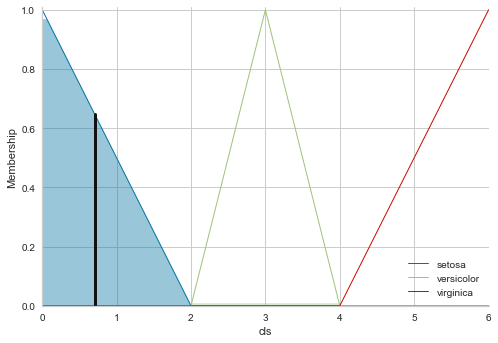

In [69]:
#setosa
simulation.inputs({
    'sepal_length': 1.0,
    'sepal_width': 0.772727,
    'petal_length':0.181818,
    'petal_width': 0.0
})
# Crunch the numbers
simulation.compute()

cls.view(sim=simulation) 

In [70]:
simulation.output['cls']

0.7072855281466337

In [71]:
RESULT = simulation.output['cls']
print("Pertinence tip setosa: \t" + str(fuzz.interp_membership(cls.universe, cls['setosa'].mf, RESULT)))
print("Pertinence tip versicolor: \t" + str(fuzz.interp_membership(cls.universe, cls['versicolor'].mf, RESULT)))
print("Pertinence tip virginica: \t" + str(fuzz.interp_membership(cls.universe, cls['virginica'].mf, RESULT)))

Pertinence tip setosa: 	0.6463572359266831
Pertinence tip versicolor: 	0.0
Pertinence tip virginica: 	0.0


C:\Users\angel\anaconda3\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


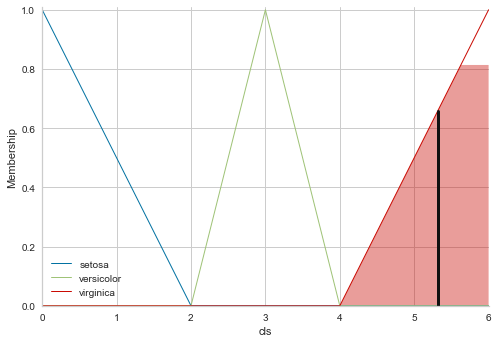

In [72]:
#Virginica 
simulation.inputs({
    'sepal_length': 1.0,
    'sepal_width': 0.055556,
    'petal_length':0.851852,
    'petal_width': 0.0
})
# Crunch the numbers
simulation.compute()

cls.view(sim=simulation) 

In [73]:
simulation.output['cls']

5.31380273850549

In [74]:
RESULT = simulation.output['cls']
print("Pertinence tip setosa: \t" + str(fuzz.interp_membership(cls.universe, cls['setosa'].mf, RESULT)))
print("Pertinence tip versicolor: \t" + str(fuzz.interp_membership(cls.universe, cls['versicolor'].mf, RESULT)))
print("Pertinence tip virginica: \t" + str(fuzz.interp_membership(cls.universe, cls['virginica'].mf, RESULT)))

Pertinence tip setosa: 	0.0
Pertinence tip versicolor: 	0.0
Pertinence tip virginica: 	0.6569013692527448


C:\Users\angel\anaconda3\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


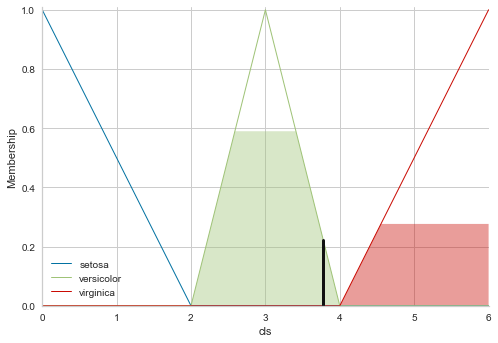

In [75]:
#Versicolor 
simulation.inputs({
    'sepal_length': 1.0,
    'sepal_width': 0.319149,
    'petal_length':0.702128,
    'petal_width': 0.0
})
# Crunch the numbers
simulation.compute()

cls.view(sim=simulation) 

In [76]:
simulation.output['cls']

3.7763753696900833

In [77]:
RESULT = simulation.output['cls']
print("Pertinence tip setosa: \t" + str(fuzz.interp_membership(cls.universe, cls['setosa'].mf, RESULT)))
print("Pertinence tip versicolor: \t" + str(fuzz.interp_membership(cls.universe, cls['versicolor'].mf, RESULT)))
print("Pertinence tip virginica: \t" + str(fuzz.interp_membership(cls.universe, cls['virginica'].mf, RESULT)))

Pertinence tip setosa: 	0.0
Pertinence tip versicolor: 	0.22362463030991675
Pertinence tip virginica: 	0.0


In [78]:
def aplicar_classificacao_regra(dicionario):
    simulation.inputs(dicionario)
    # Crunch the numbers
    simulation.compute()
    result = simulation.output['cls']
    d = {
        'Iris-setosa' : fuzz.interp_membership(cls.universe, cls['setosa'].mf, result),
        'Iris-versicolor' : fuzz.interp_membership(cls.universe, cls['versicolor'].mf, result),
        'Iris-virginica' : fuzz.interp_membership(cls.universe, cls['virginica'].mf, result)
    }
    return max(d, key=d.get)


base_padronizada['preditado'] = base_padronizada.apply(lambda x: aplicar_classificacao_regra({
    'sepal_length': x['sepal length'],
    'sepal_width': x['sepal width'],
    'petal_length': x['petal length'],
    'petal_width': x['petal width']
}), axis=1)

In [79]:
base_padronizada

,sepal length,sepal width,petal length,petal width,class,preditado
0,1.0,0.673469,0.244898,0.0,Iris-setosa,Iris-setosa
1,1.0,0.595745,0.255319,0.0,Iris-setosa,Iris-setosa
2,1.0,0.666667,0.244444,0.0,Iris-setosa,Iris-setosa
3,1.0,0.659091,0.295455,0.0,Iris-setosa,Iris-setosa
4,1.0,0.708333,0.250000,0.0,Iris-setosa,Iris-setosa
...,...,...,...,...,...,...
145,1.0,0.159091,0.659091,0.0,Iris-virginica,Iris-virginica
146,1.0,0.136364,0.704545,0.0,Iris-virginica,Iris-virginica
147,1.0,0.222222,0.711111,0.0,Iris-virginica,Iris-virginica
148,1.0,0.282051,0.794872,0.0,Iris-virginica,Iris-virginica


In [80]:
base_padronizada[base_padronizada['class'] == 'Iris-setosa']

,sepal length,sepal width,petal length,petal width,class,preditado
0,1.0,0.673469,0.244898,0.0,Iris-setosa,Iris-setosa
1,1.0,0.595745,0.255319,0.0,Iris-setosa,Iris-setosa
2,1.0,0.666667,0.244444,0.0,Iris-setosa,Iris-setosa
3,1.0,0.659091,0.295455,0.0,Iris-setosa,Iris-setosa
4,1.0,0.708333,0.250000,0.0,Iris-setosa,Iris-setosa
5,1.0,0.700000,0.260000,0.0,Iris-setosa,Iris-setosa
6,1.0,0.720930,0.255814,0.0,Iris-setosa,Iris-setosa
7,1.0,0.666667,0.270833,0.0,Iris-setosa,Iris-setosa
8,1.0,0.642857,0.285714,0.0,Iris-setosa,Iris-setosa
9,1.0,0.625000,0.291667,0.0,Iris-setosa,Iris-setosa


In [81]:
base_padronizada[base_padronizada['class'] == 'Iris-versicolor']

,sepal length,sepal width,petal length,petal width,class,preditado
50,1.0,0.321429,0.589286,0.0,Iris-versicolor,Iris-versicolor
51,1.0,0.346939,0.612245,0.0,Iris-versicolor,Iris-versicolor
52,1.0,0.296296,0.629630,0.0,Iris-versicolor,Iris-versicolor
53,1.0,0.238095,0.642857,0.0,Iris-versicolor,Iris-versicolor
54,1.0,0.260000,0.620000,0.0,Iris-versicolor,Iris-versicolor
55,1.0,0.340909,0.727273,0.0,Iris-versicolor,Iris-versicolor
56,1.0,0.361702,0.659574,0.0,Iris-versicolor,Iris-versicolor
57,1.0,0.358974,0.589744,0.0,Iris-versicolor,Iris-versicolor
58,1.0,0.301887,0.622642,0.0,Iris-versicolor,Iris-versicolor
59,1.0,0.342105,0.657895,0.0,Iris-versicolor,Iris-versicolor


In [82]:
base_padronizada[base_padronizada['class'] == 'Iris-virginica']

,sepal length,sepal width,petal length,petal width,class,preditado
100,1.0,0.210526,0.921053,0.0,Iris-virginica,Iris-virginica
101,1.0,0.205128,0.820513,0.0,Iris-virginica,Iris-virginica
102,1.0,0.180000,0.760000,0.0,Iris-virginica,Iris-virginica
103,1.0,0.244444,0.844444,0.0,Iris-virginica,Iris-virginica
104,1.0,0.186047,0.837209,0.0,Iris-virginica,Iris-virginica
105,1.0,0.163636,0.818182,0.0,Iris-virginica,Iris-virginica
106,1.0,0.250000,0.875000,0.0,Iris-virginica,Iris-virginica
107,1.0,0.200000,0.818182,0.0,Iris-virginica,Iris-virginica
108,1.0,0.142857,0.816327,0.0,Iris-virginica,Iris-virginica
109,1.0,0.234043,0.765957,0.0,Iris-virginica,Iris-virginica


In [83]:
#base_padronizada.drop(['preditado'], axis=1).to_csv('padronizado_iris.csv', index=False, header=True, sep=';')

In [100]:
true_label = np.array(base_padronizada['class'])
pred_label = np.array(base_padronizada['preditado'])

In [102]:
matriz_confusao = confusion_matrix(true_label, pred_label)
matriz_confusao

array([[50,  0,  0],
       [ 0, 47,  3],
       [ 0,  6, 44]], dtype=int64)

In [103]:
quantidade_instancias = base_padronizada.shape[0]
quantidade_instancias

150

In [99]:
acuracia = sum(matriz_confusao.diagonal())/quantidade_instancias

In [104]:
acuracia * 100

94.0